# Train Artificial Neural Network (ANN)

Here, an Artificial Neural Network model is implemented in TensorFlow deep learning library. ANN  to mimic the learning pattern of natural biological neural networks. In comparison with the linear regression machine learning techniques, ANN are powerful tools to approximate nonlinear function from massive amount of data. A brief introduction in ANN basics can be found [here](https://becominghuman.ai/basics-of-neural-network-bef2ba97d2cf). 

A feed-forward ANN model is developed to check if it is a better option to linear regression method for water quality prediction. The following steps are applied to build and optimize ANN model in Keras platform.

1. Prepare data
2. Implement ANN in Keras
   + Build a computational graph, this can be any mathematical operation TensorFlow supports.
   + Initialize variables, to compile the variables defined previously
   + Create session, this is where the magic starts!
   + Run graph in session, the compiled graph is passed to the session, which starts its execution.
   + Close session, shutdown the session
3. Apply hyperparametrization
4. Preict
https://stackabuse.com/using-machine-learning-to-predict-the-weather-part-3/

https://github.com/CeciliaXiYang/neural-network-projects/blob/master/My%20first%20Neural%20Network%20with%20Keras/source.ipynb

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
PYTHONHASHSEED=0
np.random.seed(1337)
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Dropout
from keras.layers import Input, Dense
from keras import backend
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasRegressor

%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

dataset = pd.read_csv('combined_2007&2012.csv')[['date', 'epa_reg', 'lake_origin', 'ph', 'turb', 'doc', 'cond', 'tn', 'tp']]
dataset.head()

Using TensorFlow backend.


,date,epa_reg,lake_origin,ph,turb,doc,cond,tn,tp
0,2007-07-31,Region_8,NATURAL,7.63,0.474,0.63,96.28,0.151,6.0
1,2007-06-14,Region_4,MAN-MADE,6.05,3.55,14.02,44.80,0.695,36.0
2,2007-07-23,Region_4,MAN-MADE,5.92,4.43,13.80,42.87,0.507,25.0
3,2007-08-29,Region_6,NATURAL,8.47,7.67,6.00,1089.00,0.738,43.0
4,2007-09-06,Region_6,NATURAL,8.54,9.53,5.87,1120.00,0.843,50.0


In [2]:
### Import performance from linear regression
performance = pd.read_csv('performance.csv',  index_col = 'Model')
del performance['Unnamed: 0']
del performance['Number of Features']
performance

,Root Mean Squared Error (testing),R-squared (testing),Adjusted R-squared (testing),R-squared (training),Adjusted R-squared (training),5-Fold Cross Validation
Model,,,,,,
Multiple Linear Regression,1.36,0.53,0.53,0.63,0.63,0.5


## Prepare Data

The number of features to be used are limited to pH, turbidity and conductivity, which were identified as most correlated to total phosphorus and nitrogen and relatively cheaper to monitor.

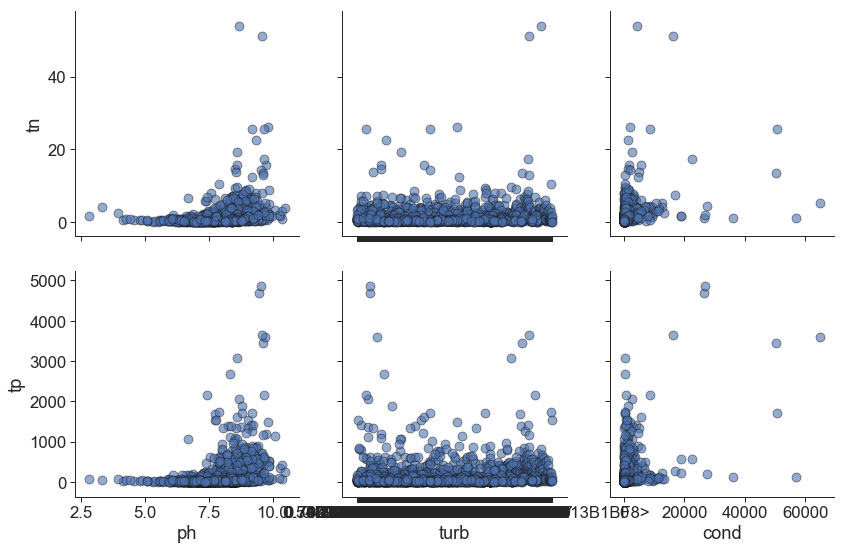

In [3]:
sns.set(style="ticks", color_codes=True)
#fig, ax = plt.subplots(figsize=(15,6))
sns.set_context("paper", font_scale=1.9)
sns.pairplot( data = dataset, y_vars =['tn', 'tp'], x_vars =['ph', 'turb', 'cond'],size = 4, plot_kws = {'alpha': 0.6, 's': 80, 'edgecolor': 'k'}, diag_kind='kde')

In [4]:
dataset['turb'] = pd.to_numeric(dataset['turb'], errors='coerce')
dataset.dropna(inplace = True)
dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
ph,2421.0,8.053342,0.802292,2.830,7.530,8.230,8.570,10.47
turb,2421.0,11.337008,30.971168,0.010,1.200,3.110,9.000,574.00
doc,2421.0,8.654358,17.744923,0.230,3.340,5.450,8.820,515.81
cond,2421.0,698.517125,2897.422916,2.820,79.650,229.200,462.000,64810.00
tn,2421.0,1.164621,2.349003,0.005,0.314,0.604,1.204,54.00
tp,2421.0,114.624948,288.098436,0.000,14.000,35.000,94.000,4865.00


## Splitting the Data set
The whole dataset is approtioned into train and test data, with a plit of 75 % and 25 %, respectively.

In [594]:
low = .03
high = .98
quant_df = dataset.quantile([low, high])
print(quant_df)

         ph    turb     doc      cond      tn     tp
0.03  6.480   0.340   1.180    18.042  0.0896    3.0
0.98  9.446  81.914  37.798  4560.000  6.2018  837.0


In [595]:
datas = dataset[dataset['epa_reg']=='Region_1']

In [618]:
dataset['turb'] = dataset['turb'].fillna(dataset['turb'].mean())
filt_df = dataset[['ph', 'turb', 'cond', 'tn', 'tp']]
filt_df = filt_df.apply(lambda x: x[(x>quant_df.loc[low,x.name]) & 
                                    (x < quant_df.loc[high,x.name])], axis=0).dropna()

In [616]:
filt_df.isnull().sum()

doc     119
ph      120
turb    119
cond    118
tn      118
tp      127
dtype: int64

In [619]:
dataset = dataset.sample(frac=1)
train, test = train_test_split(dataset,train_size = 0.75, random_state = 2)

In [620]:
feature_name = ['ph', 'turb', 'cond']
label_name = ['tn', 'tp']

In [621]:
train_data= train[feature_name]
train_labels = train[label_name]
tn_train_labels = train_labels['tn']
tp_train_labels = train_labels['tp']

In [622]:
test_data= test[feature_name]
test_labels = test[label_name]
tn_test_labels = test_labels['tn']
tp_test_labels = test_labels['tp']

### Normalize Data
To avoid bias due to the difference in scale of all input features, the data set is mormalized to a scale of [0,1]. 

In [623]:
train_data_norm = train_data.apply(lambda x: (x-x.mean())/(x.std()))
test_data_norm = test_data.apply(lambda x: (x-x.mean())/(x.std()))
train_labels_norm = train_labels.apply(lambda x: (x-x.mean())/(x.std()))
test_labels_norm = test_labels.apply(lambda x: (x-x.mean())/(x.std()))

In [624]:
train_data_norm.describe()

,ph,turb,cond
count,1.815000e+03,1.815000e+03,1.815000e+03
mean,-1.017857e-15,-1.957418e-17,3.914836e-18
std,1.000000e+00,1.000000e+00,1.000000e+00
min,-6.451130e+00,-3.628997e-01,-2.316411e-01
25%,-6.671018e-01,-3.243154e-01,-2.069602e-01
50%,2.227486e-01,-2.642776e-01,-1.591404e-01
75%,6.429557e-01,-7.920116e-02,-8.534598e-02
max,2.991172e+00,1.801635e+01,1.987519e+01


In [698]:
mlp = MLPRegressor(solver='lbfgs', # we use the adam optimizer,
                   alpha = 0.0001,
                   max_iter = 30000,
                   learning_rate_init = 0.0001,
                   activation='relu', # activation function is the rectified linear unit function, returns f(x) = max(0, x)
                   hidden_layer_sizes=(20,4), # one hidden layer of 500 nodes 
                   random_state = 9)
mlp.fit(train_data_norm, train_labels_norm)
y_pred = mlp.predict(train_data_norm)
r2_score(train_labels_norm, y_pred)

0.6751963921124527

In [699]:
y_pred = mlp.predict(test_data_norm)
r2_score(test_labels_norm, y_pred)

0.48312149929445175

In [700]:
scores = cross_val_score(mlp, filt_df[feature_name], filt_df[label_name], cv = 5)
scores.mean()

0.37234784436165325

In [563]:
from sklearn.linear_model import LinearRegression
mlr = LinearRegression()
mlr.fit(train_data, train_labels)

pred1 = mlr.predict(test_data)

r2_train = mlr.score(train_data,train_labels)
r2_test = mlr.score(test_data,test_labels)

In [329]:
r2_test

0.4346953038385824

## Build the ANN model

ANN is built from three major building blocks: input , hidden, and output layers. The number of neurons (nodes) in the input and output are the number of features and labels, respectively. The number of neurons in hidden layer (s) to be used for the baseline model can be estimated based on data size. Once the baseline model is built, a set of techniques will be applied to imporve computational pefromance.

For now, a basline model is built with one hidden layer in [Keras plotform with Tensorflow backend](https://www.tensorflow.org/guide/keras). The initial number of hidden nodes is determined using a rule of thump.

### Estimate initinial number of hidden nodes

In [11]:
# rule of thump to determine number of hidden nodes
def num_hidd_nodes(n_features, n_labels, num_samles_train):
    hidden_nodes = []
    for α in range (2, 11): # α = 2-10 is a commnoly used arbitrary scaling factor
        nodes = int(num_samles_train/(α + (n_features + n_labels)))
        hidden_nodes.append(nodes)
    return hidden_nodes

In [12]:
n_features = train.shape[1]
n_train_sample = train.shape[0]
n_labels = test.shape[1]
hidden_nodes = num_hidd_nodes(n_features, n_labels, n_train_sample)
hidden_nodes[::-1]

[35, 37, 38, 40, 42, 44, 46, 48, 51]

According to the rule of thump estimate, a hidden node within 46 to 77 range is optimial

#### Visualize NN architecture 

For visualization purpose, a hidden node of 10 (not 46-77) is used here. 

In [13]:
def draw_neural_net(ax, left, right, bottom, top, layer_sizes):
    n_layers = len(layer_sizes)
    v_spacing = (top - bottom)/float(max(layer_sizes))
    h_spacing = (right - left)/float(len(layer_sizes) - 1)
    # Nodes
    for n, layer_size in enumerate(layer_sizes):
        layer_top = v_spacing*(layer_size - 1)/2. + (top + bottom)/2.
        for m in range(layer_size):
            circle = plt.Circle((n*h_spacing + left, layer_top - m*v_spacing), v_spacing/4.,
                                color='w', ec='k', zorder=4)
            ax.add_artist(circle)
    # Edges
    for n, (layer_size_a, layer_size_b) in enumerate(zip(layer_sizes[:-1], layer_sizes[1:])):
        layer_top_a = v_spacing*(layer_size_a - 1)/2. + (top + bottom)/2.
        layer_top_b = v_spacing*(layer_size_b - 1)/2. + (top + bottom)/2.
        for m in range(layer_size_a):
            for o in range(layer_size_b):
                line = plt.Line2D([n*h_spacing + left, (n + 1)*h_spacing + left],
                                  [layer_top_a - m*v_spacing, layer_top_b - o*v_spacing], c='k')
                ax.add_artist(line)

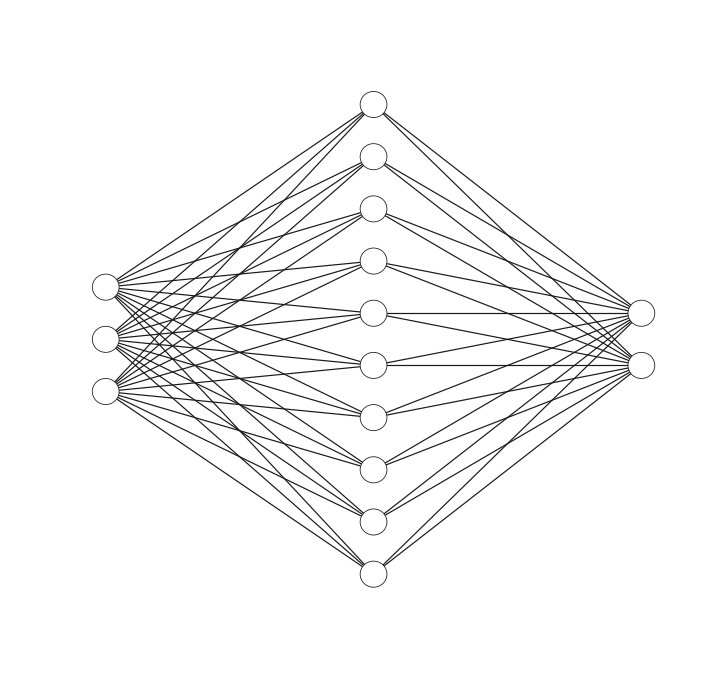

In [14]:
fig = plt.figure(figsize=(12, 12))
ax = fig.gca()
ax.axis('off')
draw_neural_net(ax, .1, .9, .1, .9, [3, 10, 2])

## Build Baseline Model
A Sequential model with an input layer, one hidden layer, and an output layer that returns two continuous value features is developed as a baseline model.

In [41]:
# error metrics
def r_square(y_true, y_pred):
    SS_res =  backend.sum(backend.square(y_true - y_pred)) 
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot))

def rmse(y_true, y_pred):
    return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

def adjustedR2(r2,n,k):
    return r2-(k-1)/(n-k)*(1-r2)

In [42]:
def build_model(optimizer, learning_rate, epochs, neuron_lay1, neuron_lay2):
    #neurons, train, test, optimizer, learning_rate, epoch
    model = keras.Sequential([
    # The Input Layer :
    layers.Dense(neuron_lay1, activation = tf.nn.relu, input_shape=[train_data_norm.shape[1]], kernel_initializer='random_uniform'),
    # The Hidden Layers :
    layers.Dense(neuron_lay2, activation = tf.nn.relu),
    #layers.Dense(neurons, activation = tf.nn.relu),
    # The Output Layer :
    layers.Dense(2, activation = 'sigmoid'),
    ])
    
    #model.add(BatchNormalization(),
    #model.add(layers.Dropout(0.1))
                       
    #optimizer = tf.keras.optimizers.Adam(learning_rate)
    
    model.compile(loss = 'mean_squared_error',
                optimizer = 'SGD',
                metrics = [r_square, rmse,'mean_squared_error', 'acc'])
    return model

In [290]:
#optimizer : https://www.kaggle.com/residentmario/keras-optimizers
neuron_lay1 = 20
neuron_lay2 = 4
learning_rate = 0.001
epochs = 1000
optimizer = 'rmsprop'
model_baseline = build_model(optimizer, learning_rate, epochs, neuron_lay1, neuron_lay2)
history_baseline = model_baseline.fit(train_data_norm, train_labels_norm, epochs=epochs, verbose=0, shuffle=False)

In [291]:
model_baseline.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 20)                100       
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 84        
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 10        
Total params: 194
Trainable params: 194
Non-trainable params: 0
_________________________________________________________________


In [292]:
model_baseline.metrics_names

['loss', 'r_square', 'rmse', 'mean_squared_error', 'acc']

In [293]:
model_baseline.evaluate(test_data_norm, test_labels_norm, verbose = 0)

[0.6807861195464558, 0.2095939, 0.63399714, 0.68078613, 0.699793]

In [53]:
inputs = Input(shape=(3,))
hidden_1 = Dense(20, activation='relu')(inputs)
hidden_2 = Dense(4, activation='relu')(hidden_1)
output = Dense(2, activation='sigmoid')(hidden_2)
model3 = Model(inputs=inputs, outputs=output)

In [54]:
model3.compile(optimizer='rmsprop',
              loss='mean_squared_error',
             metrics = [r_square, rmse,'mean_squared_error', 'acc'])
model3.fit(train_data_norm, train_labels_norm, epochs=5000, verbose=0, shuffle=False)

In [55]:
model3.evaluate(test_data_norm, test_labels_norm, verbose = 0)

[0.806251416177106,
 0.215911323307482,
 0.5126599619481217,
 0.806251416177106,
 0.7934560332074]

In [ ]:
np.random.seed(42)
    # create model
estimator = KerasRegressor(build_fn=build_model, train_data_norm, train_labels_norm, epochs=epochs, verbose=0)
kfold = KFold(n_splits=10, random_state=42)
results = cross_val_score(estimator, X_train, y_train, cv=kfold)  
print("Standardized: %.2f (%.2f) MSE" % (results.mean(), results.std()))
estimator

In [37]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    fig = plt.rcParams.update({'font.size': 22})
    %matplotlib inline
  
    fig = plt.figure(figsize=(18,6))
    ax1 = fig.add_subplot(121)
    ax1.plot(hist['epoch'], np.abs(hist['acc']),label='MSE')
    plt.xlabel('Epoch', fontsize = 13)
    plt.ylabel('Accuracy')
    plt.legend(fontsize=15)
    
    ax2 = fig.add_subplot(122)
    ax2.plot(hist['epoch'], hist['rmse'],label='Train RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Square Error')
    plt.legend(fontsize=15)
    plt.show()

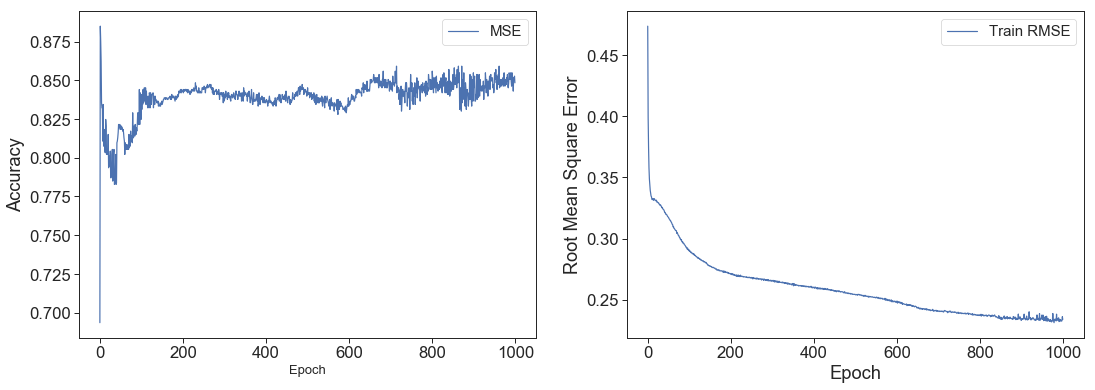

In [38]:
plot_history(history_baseline)

The network is learning as the number of iterations increased from 0 to 20000. From training RMSE plot, we can see that the network improves linearly as the epoch size increases. This indicates a larger epotch size needed to allow the model learn flexibly. To avoid computational complexity, grid search will be applied to tun up optimizer, learning rate, and number of neurons at a smaller epotch size. Then, the network will be trained under a larger epotch number configuration. 

## Grid Search 

Due to time complexity, I will implement grid search in a seperate sections.

In [60]:
# grid search for optimizer
optimizers = ['SGD', 'adam', 'Adagrad', 'RMSprop', 'Adadelta']
epochs = [100]
neurons = [43]
learning_rate = 0.001

estimator = KerasRegressor(build_fn = build_model, verbose=0)
param_grid = dict(optimizer = optimizers, learning_rate = learning_rate, epochs=epochs, neurons=neurons)
grid = GridSearchCV(estimator = estimator, param_grid=param_grid)
# neurons, train_data_norm, train_labels_norm, learning_rate, epoch
grid_result = grid.fit(train_data_norm, train_labels_norm)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.790896 using {'epochs': 100, 'neurons': 43, 'optimizer': 'RMSprop'}
-0.803891 (0.141745) with: {'epochs': 100, 'neurons': 43, 'optimizer': 'SGD'}
-0.799638 (0.149903) with: {'epochs': 100, 'neurons': 43, 'optimizer': 'adam'}
-0.806010 (0.145606) with: {'epochs': 100, 'neurons': 43, 'optimizer': 'Adagrad'}
-0.790896 (0.145510) with: {'epochs': 100, 'neurons': 43, 'optimizer': 'RMSprop'}
-0.799797 (0.140924) with: {'epochs': 100, 'neurons': 43, 'optimizer': 'Adadelta'}


In [45]:
# grid search for neurons
optimizers = ['RMSprop']
epochs = [100]
neurons = hidden_nodes
learning_rate = 0.001

estimator = KerasRegressor(build_fn = build_model, verbose=0)
param_grid = dict(optimizer = optimizers, epochs=epochs, learning_rate = learning_rate, neurons=neurons)
grid = GridSearchCV(estimator = estimator, param_grid=param_grid)
# neurons, train_data_norm, train_labels_norm, learning_rate, epoch
grid_result = grid.fit(train_data_norm, train_labels_norm)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.801126 using {'epochs': 100, 'neurons': 51, 'optimizer': 'RMSprop'}
-0.801126 (0.150730) with: {'epochs': 100, 'neurons': 51, 'optimizer': 'RMSprop'}
-0.817770 (0.173544) with: {'epochs': 100, 'neurons': 48, 'optimizer': 'RMSprop'}
-0.816096 (0.160057) with: {'epochs': 100, 'neurons': 46, 'optimizer': 'RMSprop'}
-0.807211 (0.140997) with: {'epochs': 100, 'neurons': 44, 'optimizer': 'RMSprop'}
-0.808561 (0.146152) with: {'epochs': 100, 'neurons': 42, 'optimizer': 'RMSprop'}
-0.814393 (0.147248) with: {'epochs': 100, 'neurons': 40, 'optimizer': 'RMSprop'}
-0.810805 (0.145513) with: {'epochs': 100, 'neurons': 38, 'optimizer': 'RMSprop'}
-0.809969 (0.145170) with: {'epochs': 100, 'neurons': 37, 'optimizer': 'RMSprop'}
-0.801858 (0.145779) with: {'epochs': 100, 'neurons': 35, 'optimizer': 'RMSprop'}


In [35]:
# grid search for neurons
optimizers = ['RMSprop']
epochs = [1000]
neurons = [51]
learning_rate = [0.0001, 0.001, 0.01, 0.1]

estimator = KerasRegressor(build_fn = build_model, verbose=0)
param_grid = dict(optimizer = optimizers, epochs=epochs, learning_rate = learning_rate, neurons=neurons)
grid = GridSearchCV(estimator = estimator, param_grid=param_grid)
# neurons, train_data_norm, train_labels_norm, learning_rate, epoch
grid_result = grid.fit(train_data_norm, train_labels_norm)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: -0.805454 using {'epochs': 1000, 'learning_rate': 0.0001, 'neurons': 51, 'optimizer': 'RMSprop'}
-0.805454 (0.148574) with: {'epochs': 1000, 'learning_rate': 0.0001, 'neurons': 51, 'optimizer': 'RMSprop'}
-0.807700 (0.142935) with: {'epochs': 1000, 'learning_rate': 0.001, 'neurons': 51, 'optimizer': 'RMSprop'}
-0.812777 (0.131925) with: {'epochs': 1000, 'learning_rate': 0.01, 'neurons': 51, 'optimizer': 'RMSprop'}
-0.813248 (0.140692) with: {'epochs': 1000, 'learning_rate': 0.1, 'neurons': 51, 'optimizer': 'RMSprop'}


From the grid search, the optimum model parameter values are
+ Number of neurons = 51
+ learning_rate = 0.0001
+ optimizer = 'rmsprop'

### Evaluate Model

In [129]:
model_baseline.evaluate(test_data_norm, test_labels_norm, verbose = 0)

[1.0865332041522697, -0.6363548, 0.7587685, 1.0865333, 0.12861736]

In [82]:
test_predictions = model.predict(test_data_norm).flatten()
train_predictions = model.predict(train_data_norm).flatten()
#r2_score(test_predictions[])

In [85]:
test_predictions[:,0]

IndexError: too many indices for array

#### Optimum model performance 

In [ ]:
def build_model(learning_rate, epochs, neurons):
    #neurons, train, test, optimizer, learning_rate, epoch
    model = keras.Sequential([
    # The Input Layer :
    layers.Dense(neurons, activation = tf.nn.relu, input_shape=[train_data_norm.shape[1]]),
    # The Hidden Layers :
    layers.Dense(neurons, activation = tf.nn.relu),
    layers.Dense(neurons, activation = tf.nn.relu),
    # The Output Layer :
    layers.Dense(2, activation = tf.keras.activations.sigmoid),
    ])
    
    model.add(layers.Dropout(0.2))
                       
    optimizer = tf.keras.optimizers.RMSprop(learning_rate)
    cv = float(format(cross_val_score(model,data[features], data[target], cv = 5).mean(),'.3f'))
    model.compile(loss = 'mean_squared_error',
                optimizer = optimizer,
                metrics = [r_square, rmse,'mean_squared_error', 'acc'])
    return model

In [55]:
feature = ['ph', 'cond', 'turb']
target = ['tn', 'tp']
estimator = KerasRegressor(build_fn=build_model, learning_rate = 0.0001, neurons = 51,
                           optimizer = 'rmspop', epochs = 1000, verbose=False)
kfold = KFold(n_splits=5, random_state = 2)
x = data.apply(lambda x: (x-x.min())/(x.std())
results = cross_val_score(estimator, x[feature], x[target], cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

SyntaxError: invalid syntax (<ipython-input-55-d8c2896dd6d7>, line 7)

(-133.46529940262846,
 2803.5092994026286,
 -0.062279299162520146,
 2936.9123195060943)

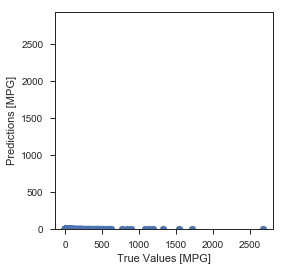

In [40]:
test_predictions = model.predict(test_data_norm).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')

The best optimizer in this dataset seems the RMSprpo. 

https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/

## Experiment with data to Optimize Model Performance

Water quality condition is greately shaped by regional factors. The quality of water change with the changes in environmental homeginity. These environmental changes may have both positive and negative impact on the quality of water. This step applies modeling experiment with the dataset that are seperated regions. The datasets is separated into 10 U.S. EPA regions(smaller geographical units).

![US Regions](us_regions.png)

### Separate Regional Data

In [47]:
regions = pd.Series(data['epa_reg']).unique()
regions

array(['Region_8', 'Region_4', 'Region_6', 'Region_10', 'Region_1',
       'Region_5', 'Region_7', 'Region_2', 'Region_3', 'Region_9'],
      dtype=object)

In [48]:
regional_data = {}
for region in regions:
    regional_data[region] = data[data['epa_reg']==region]
print('Region 1 data first five rows:' '\n' + '-'*32)
regional_data['Region_1'].head()

Region 1 data first five rows:
--------------------------------


,date,epa_reg,lake_origin,ph,turb,cond,tn,tp
9,2007-07-17,Region_1,MAN-MADE,7.06,0.901,74.74,0.184,7.0
10,2007-08-30,Region_1,MAN-MADE,7.49,1.150,77.04,0.229,6.0
47,2007-07-13,Region_1,NATURAL,7.15,2.590,98.02,0.239,14.0
48,2007-09-05,Region_1,NATURAL,7.72,2.200,103.20,0.301,11.0
49,2007-07-12,Region_1,NATURAL,7.62,0.549,59.70,0.158,4.0


In [49]:
print('Region 9 data first five rows:' '\n' + '-'*32)
regional_data['Region_9'].head()

Region 9 data first five rows:
--------------------------------


,date,epa_reg,lake_origin,ph,turb,cond,tn,tp
70,2007-06-12,Region_9,MAN-MADE,8.50,3.020,775.8,0.495,20.0
71,2007-08-22,Region_9,MAN-MADE,8.50,3.490,779.4,0.481,19.0
88,2007-06-12,Region_9,MAN-MADE,9.45,0.519,26620.0,1.055,4679.0
89,2007-07-18,Region_9,MAN-MADE,9.53,0.752,26820.0,1.750,4865.0
134,2007-07-11,Region_9,MAN-MADE,9.01,1.980,508.0,0.641,19.0


# Train Regional Network

In [60]:
optimizers = 'RMSprop'
epochs = 100
neurons = 51
model_reg = build_model(optimizer, epochs, neurons)
performance_reg = {}
for region in regions:
    data = regional_data[region]
    data = data[['ph', 'turb', 'cond', 'tn', 'tp']]
    data = data.apply(lambda x: (x-x.min())/(x.std()))
    feature_name = ['ph', 'turb', 'cond']
    label_name = ['tn', 'tp']
    train, test = train_test_split(data,train_size = 0.75, random_state = 2)
    train_feature_norm = train[feature_name]
    train_label_norm = train[label_name]
    test_feature_norm = test[feature_name]
    test_label_norm = test[label_name]
    history_reg = model.fit(train_feature_norm, train_label_norm, epochs=epochs, verbose=1, shuffle=True)
    performance_reg[region] = history_reg

Epoch 1/100
164/164 [==============================] - 0s 220us/sample - loss: 0.8714 - r_square: 0.1525 - rmse: 0.4982 - mean_squared_error: 0.8714 - acc: 0.6829
Epoch 2/100
164/164 [==============================] - 0s 85us/sample - loss: 0.8223 - r_square: 0.1144 - rmse: 0.4907 - mean_squared_error: 0.8223 - acc: 0.6220
Epoch 3/100
164/164 [==============================] - 0s 116us/sample - loss: 0.8373 - r_square: 0.0535 - rmse: 0.4724 - mean_squared_error: 0.8373 - acc: 0.5976
Epoch 4/100
164/164 [==============================] - 0s 116us/sample - loss: 0.7536 - r_square: 0.2840 - rmse: 0.4387 - mean_squared_error: 0.7536 - acc: 0.5915
Epoch 5/100
164/164 [==============================] - 0s 98us/sample - loss: 0.8051 - r_square: 0.1493 - rmse: 0.4546 - mean_squared_error: 0.8051 - acc: 0.6585
Epoch 6/100
164/164 [==============================] - 0s 98us/sample - loss: 0.7804 - r_square: 0.2890 - rmse: 0.4469 - mean_squared_error: 0.7804 - acc: 0.5732
Epoch 7/100
164/164 [====

164/164 [==============================] - 0s 92us/sample - loss: 0.7543 - r_square: -1.0582 - rmse: 0.4060 - mean_squared_error: 0.7543 - acc: 0.6098
Epoch 1/100
87/87 [==============================] - 0s 92us/sample - loss: 0.8774 - r_square: 0.1407 - rmse: 0.5766 - mean_squared_error: 0.8774 - acc: 0.5172
Epoch 2/100
87/87 [==============================] - 0s 92us/sample - loss: 1.0025 - r_square: 0.0652 - rmse: 0.5717 - mean_squared_error: 1.0025 - acc: 0.6092
Epoch 3/100
87/87 [==============================] - 0s 92us/sample - loss: 1.0049 - r_square: 0.0968 - rmse: 0.5723 - mean_squared_error: 1.0049 - acc: 0.5287
Epoch 4/100
87/87 [==============================] - 0s 92us/sample - loss: 0.8368 - r_square: 0.1203 - rmse: 0.5644 - mean_squared_error: 0.8368 - acc: 0.5747
Epoch 5/100
87/87 [==============================] - 0s 80us/sample - loss: 0.9835 - r_square: 0.0532 - rmse: 0.5933 - mean_squared_error: 0.9835 - acc: 0.5977
Epoch 6/100
87/87 [==============================

87/87 [==============================] - 0s 104us/sample - loss: 0.9108 - r_square: 0.1111 - rmse: 0.5349 - mean_squared_error: 0.9108 - acc: 0.6897
Epoch 1/100
115/115 [==============================] - 0s 104us/sample - loss: 1.3720 - r_square: -0.2376 - rmse: 0.8249 - mean_squared_error: 1.3720 - acc: 0.6348
Epoch 2/100
115/115 [==============================] - 0s 104us/sample - loss: 1.1941 - r_square: -0.0735 - rmse: 0.7707 - mean_squared_error: 1.1941 - acc: 0.7217
Epoch 3/100
115/115 [==============================] - 0s 96us/sample - loss: 1.0681 - r_square: 0.0248 - rmse: 0.7146 - mean_squared_error: 1.0681 - acc: 0.7826
Epoch 4/100
115/115 [==============================] - 0s 87us/sample - loss: 1.1971 - r_square: -0.1659 - rmse: 0.7584 - mean_squared_error: 1.1971 - acc: 0.6348
Epoch 5/100
115/115 [==============================] - 0s 87us/sample - loss: 1.1114 - r_square: -0.0339 - rmse: 0.7050 - mean_squared_error: 1.1114 - acc: 0.7391
Epoch 6/100
115/115 [==============

115/115 [==============================] - 0s 69us/sample - loss: 1.1006 - r_square: 0.0038 - rmse: 0.6740 - mean_squared_error: 1.1006 - acc: 0.7304
Epoch 99/100
115/115 [==============================] - 0s 69us/sample - loss: 1.1780 - r_square: -0.1411 - rmse: 0.7266 - mean_squared_error: 1.1780 - acc: 0.7043
Epoch 100/100
115/115 [==============================] - 0s 78us/sample - loss: 1.2336 - r_square: -0.0897 - rmse: 0.7145 - mean_squared_error: 1.2336 - acc: 0.7652
Epoch 1/100
81/81 [==============================] - 0s 124us/sample - loss: 1.0706 - r_square: 0.1943 - rmse: 0.4325 - mean_squared_error: 1.0706 - acc: 0.7778
Epoch 2/100
81/81 [==============================] - 0s 99us/sample - loss: 1.0780 - r_square: 0.2483 - rmse: 0.4166 - mean_squared_error: 1.0780 - acc: 0.8519
Epoch 3/100
81/81 [==============================] - 0s 124us/sample - loss: 1.0722 - r_square: 0.2680 - rmse: 0.4286 - mean_squared_error: 1.0722 - acc: 0.7531
Epoch 4/100
81/81 [====================

81/81 [==============================] - 0s 86us/sample - loss: 1.0300 - r_square: 0.3480 - rmse: 0.3890 - mean_squared_error: 1.0300 - acc: 0.7654
Epoch 99/100
81/81 [==============================] - 0s 86us/sample - loss: 0.9588 - r_square: 0.2700 - rmse: 0.3756 - mean_squared_error: 0.9588 - acc: 0.8395
Epoch 100/100
81/81 [==============================] - 0s 99us/sample - loss: 0.9192 - r_square: 0.3431 - rmse: 0.3817 - mean_squared_error: 0.9192 - acc: 0.7778
Epoch 1/100
75/75 [==============================] - 0s 120us/sample - loss: 0.8277 - r_square: -1.3009 - rmse: 0.5561 - mean_squared_error: 0.8277 - acc: 0.7467
Epoch 2/100
75/75 [==============================] - 0s 93us/sample - loss: 0.7456 - r_square: -0.4494 - rmse: 0.4992 - mean_squared_error: 0.7456 - acc: 0.8000
Epoch 3/100
75/75 [==============================] - 0s 107us/sample - loss: 0.7326 - r_square: -0.2062 - rmse: 0.4835 - mean_squared_error: 0.7326 - acc: 0.8133
Epoch 4/100
75/75 [=========================

75/75 [==============================] - 0s 93us/sample - loss: 0.5668 - r_square: 0.1860 - rmse: 0.2692 - mean_squared_error: 0.5668 - acc: 0.8400
Epoch 99/100
75/75 [==============================] - 0s 93us/sample - loss: 0.6157 - r_square: 0.3520 - rmse: 0.3088 - mean_squared_error: 0.6157 - acc: 0.6933
Epoch 100/100
75/75 [==============================] - 0s 93us/sample - loss: 0.5640 - r_square: 0.4379 - rmse: 0.2667 - mean_squared_error: 0.5640 - acc: 0.7333
Epoch 1/100
192/192 [==============================] - 0s 73us/sample - loss: 1.0784 - r_square: 0.0439 - rmse: 0.4408 - mean_squared_error: 1.0784 - acc: 0.7969
Epoch 2/100
192/192 [==============================] - 0s 73us/sample - loss: 1.0683 - r_square: -0.0033 - rmse: 0.4344 - mean_squared_error: 1.0683 - acc: 0.7031
Epoch 3/100
192/192 [==============================] - 0s 68us/sample - loss: 1.0240 - r_square: 0.1418 - rmse: 0.4260 - mean_squared_error: 1.0240 - acc: 0.7552
Epoch 4/100
192/192 [=====================

192/192 [==============================] - 0s 83us/sample - loss: 1.0046 - r_square: 0.1568 - rmse: 0.3970 - mean_squared_error: 1.0046 - acc: 0.7396
Epoch 99/100
192/192 [==============================] - 0s 94us/sample - loss: 0.9845 - r_square: 0.2304 - rmse: 0.3775 - mean_squared_error: 0.9845 - acc: 0.7448
Epoch 100/100
192/192 [==============================] - 0s 73us/sample - loss: 1.1129 - r_square: 0.0491 - rmse: 0.3904 - mean_squared_error: 1.1129 - acc: 0.7656
Epoch 1/100
92/92 [==============================] - 0s 120us/sample - loss: 1.0274 - r_square: 0.1659 - rmse: 0.5397 - mean_squared_error: 1.0274 - acc: 0.5000
Epoch 2/100
92/92 [==============================] - 0s 98us/sample - loss: 1.0821 - r_square: 0.1385 - rmse: 0.5145 - mean_squared_error: 1.0821 - acc: 0.5000
Epoch 3/100
92/92 [==============================] - 0s 76us/sample - loss: 0.9805 - r_square: 0.2059 - rmse: 0.5197 - mean_squared_error: 0.9805 - acc: 0.5326
Epoch 4/100
92/92 [=======================

92/92 [==============================] - 0s 54us/sample - loss: 0.9361 - r_square: 0.3127 - rmse: 0.4642 - mean_squared_error: 0.9361 - acc: 0.5217
Epoch 99/100
92/92 [==============================] - 0s 76us/sample - loss: 0.9127 - r_square: 0.4084 - rmse: 0.4274 - mean_squared_error: 0.9127 - acc: 0.6304
Epoch 100/100
92/92 [==============================] - 0s 65us/sample - loss: 1.0305 - r_square: 0.1759 - rmse: 0.4985 - mean_squared_error: 1.0305 - acc: 0.5217
Epoch 1/100
18/18 [==============================] - 0s 167us/sample - loss: 0.8457 - r_square: 0.2436 - rmse: 0.6060 - mean_squared_error: 0.8457 - acc: 0.5000
Epoch 2/100
18/18 [==============================] - 0s 111us/sample - loss: 0.6544 - r_square: 0.4146 - rmse: 0.5224 - mean_squared_error: 0.6544 - acc: 0.5000
Epoch 3/100
18/18 [==============================] - 0s 166us/sample - loss: 0.6412 - r_square: 0.4265 - rmse: 0.5135 - mean_squared_error: 0.6412 - acc: 0.4444
Epoch 4/100
18/18 [===========================

Epoch 49/100
18/18 [==============================] - 0s 167us/sample - loss: 0.9004 - r_square: 0.1946 - rmse: 0.5083 - mean_squared_error: 0.9004 - acc: 0.5556
Epoch 50/100
18/18 [==============================] - 0s 167us/sample - loss: 0.7813 - r_square: 0.3011 - rmse: 0.4738 - mean_squared_error: 0.7813 - acc: 0.4444
Epoch 51/100
18/18 [==============================] - 0s 56us/sample - loss: 0.6674 - r_square: 0.4031 - rmse: 0.4588 - mean_squared_error: 0.6674 - acc: 0.6111
Epoch 52/100
18/18 [==============================] - 0s 111us/sample - loss: 0.8778 - r_square: 0.2148 - rmse: 0.5195 - mean_squared_error: 0.8778 - acc: 0.4444
Epoch 53/100
18/18 [==============================] - 0s 167us/sample - loss: 0.7786 - r_square: 0.3036 - rmse: 0.4582 - mean_squared_error: 0.7786 - acc: 0.6667
Epoch 54/100
18/18 [==============================] - 0s 111us/sample - loss: 0.7664 - r_square: 0.3145 - rmse: 0.4627 - mean_squared_error: 0.7664 - acc: 0.3889
Epoch 55/100
18/18 [=========

Epoch 100/100
18/18 [==============================] - 0s 167us/sample - loss: 0.7665 - r_square: 0.3144 - rmse: 0.4404 - mean_squared_error: 0.7665 - acc: 0.6667
Epoch 1/100
55/55 [==============================] - 0s 127us/sample - loss: 1.0375 - r_square: -0.0429 - rmse: 0.6397 - mean_squared_error: 1.0375 - acc: 0.4364
Epoch 2/100
55/55 [==============================] - 0s 109us/sample - loss: 0.8635 - r_square: 0.1032 - rmse: 0.5737 - mean_squared_error: 0.8635 - acc: 0.5636
Epoch 3/100
55/55 [==============================] - 0s 127us/sample - loss: 0.8854 - r_square: 0.0645 - rmse: 0.5804 - mean_squared_error: 0.8854 - acc: 0.6182
Epoch 4/100
55/55 [==============================] - 0s 109us/sample - loss: 0.9202 - r_square: 0.1064 - rmse: 0.5825 - mean_squared_error: 0.9202 - acc: 0.6000
Epoch 5/100
55/55 [==============================] - 0s 109us/sample - loss: 0.7565 - r_square: 0.2554 - rmse: 0.5315 - mean_squared_error: 0.7565 - acc: 0.5818
Epoch 6/100
55/55 [============

55/55 [==============================] - 0s 73us/sample - loss: 0.8226 - r_square: 0.0555 - rmse: 0.5008 - mean_squared_error: 0.8226 - acc: 0.6545
Epoch 1/100
48/48 [==============================] - 0s 167us/sample - loss: 1.5779 - r_square: -0.0659 - rmse: 0.8465 - mean_squared_error: 1.5779 - acc: 0.7083
Epoch 2/100
48/48 [==============================] - 0s 146us/sample - loss: 1.3870 - r_square: 0.0252 - rmse: 0.7991 - mean_squared_error: 1.3870 - acc: 0.5833
Epoch 3/100
48/48 [==============================] - 0s 146us/sample - loss: 1.2037 - r_square: 0.1828 - rmse: 0.7090 - mean_squared_error: 1.2037 - acc: 0.7292
Epoch 4/100
48/48 [==============================] - 0s 125us/sample - loss: 1.2699 - r_square: 0.0367 - rmse: 0.7178 - mean_squared_error: 1.2699 - acc: 0.7708
Epoch 5/100
48/48 [==============================] - 0s 125us/sample - loss: 1.1163 - r_square: 0.1953 - rmse: 0.6876 - mean_squared_error: 1.1163 - acc: 0.8333
Epoch 6/100
48/48 [===========================

48/48 [==============================] - 0s 83us/sample - loss: 1.0356 - r_square: 0.2892 - rmse: 0.5938 - mean_squared_error: 1.0356 - acc: 0.8542


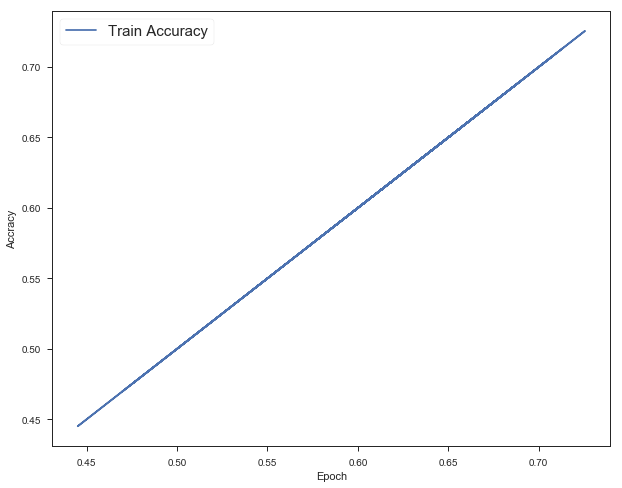

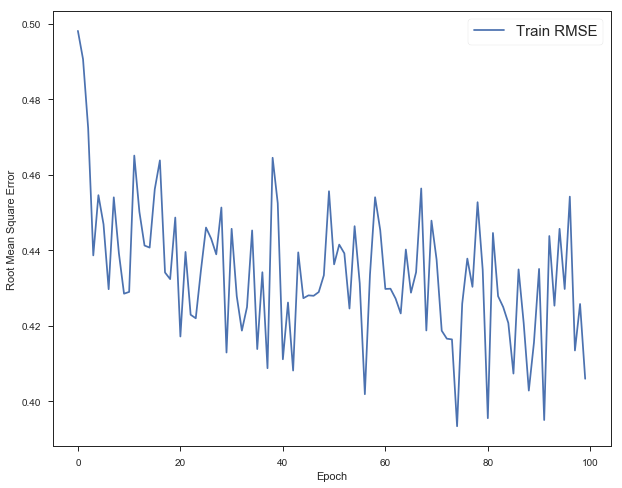

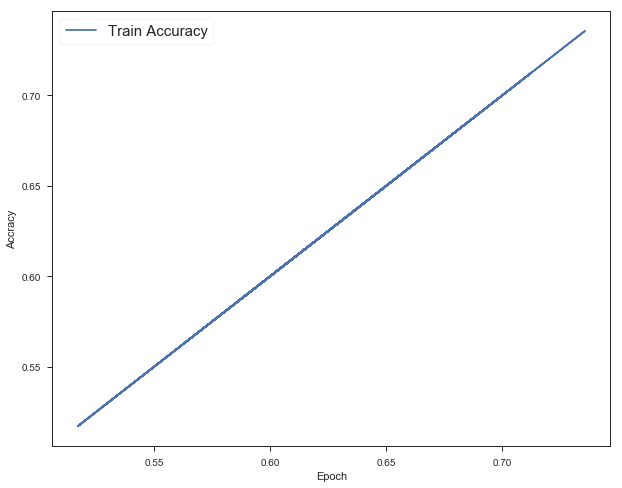

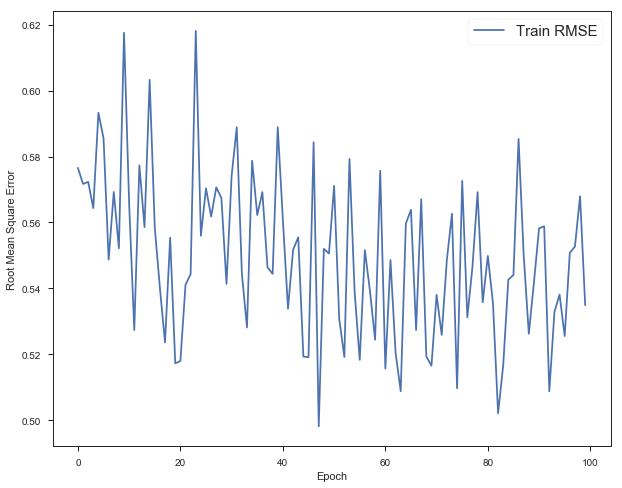

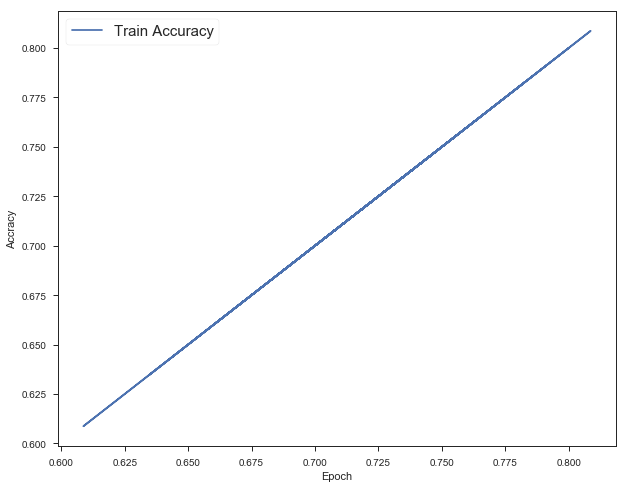

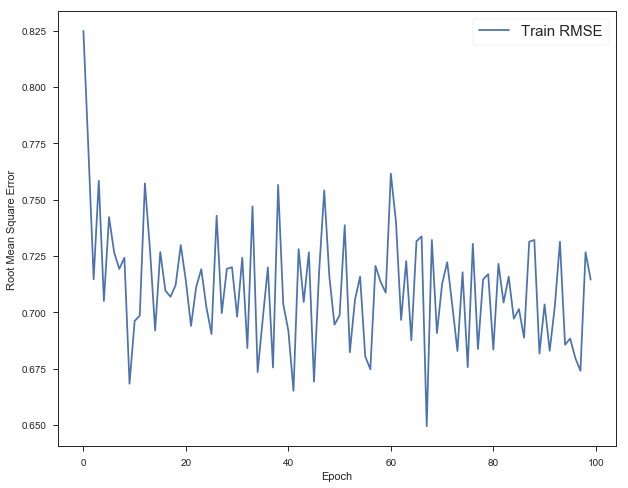

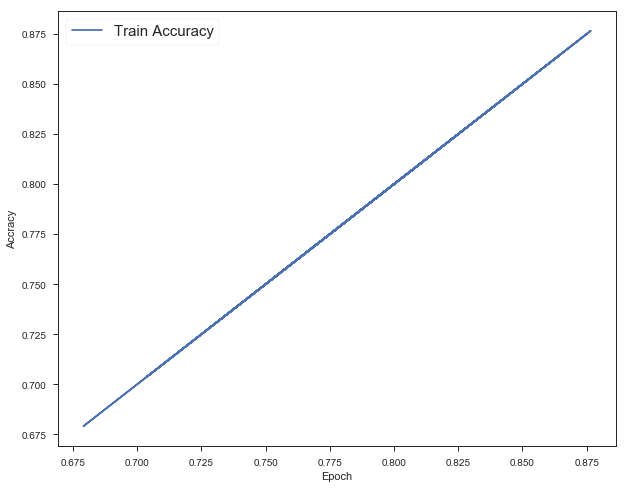

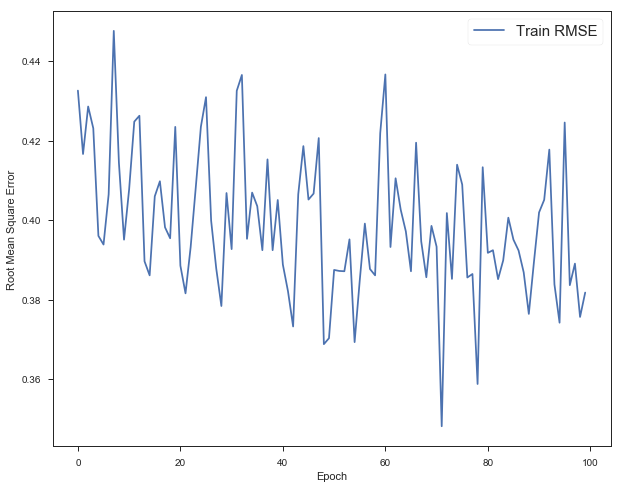

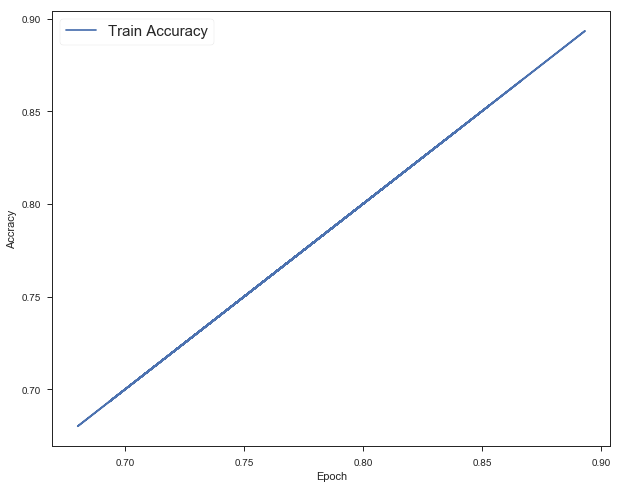

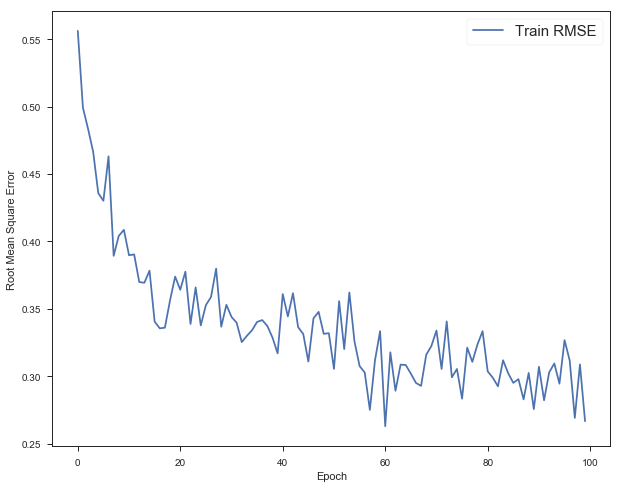

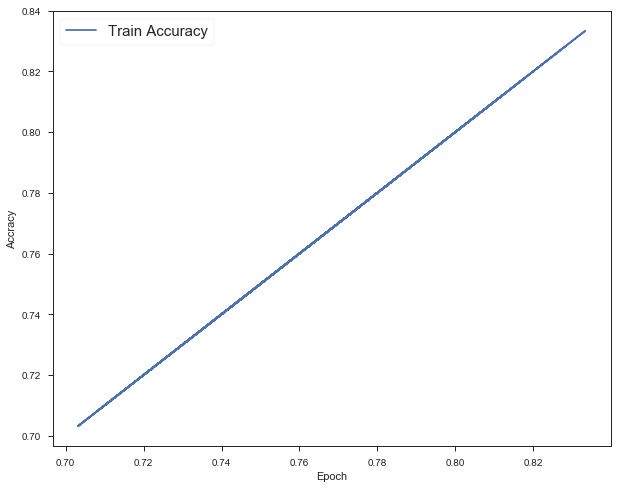

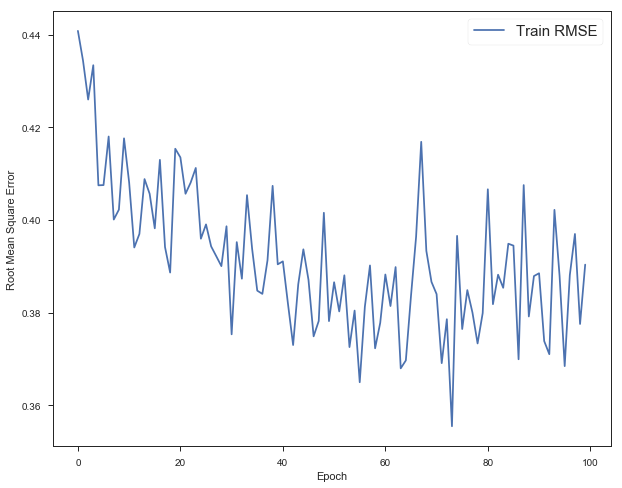

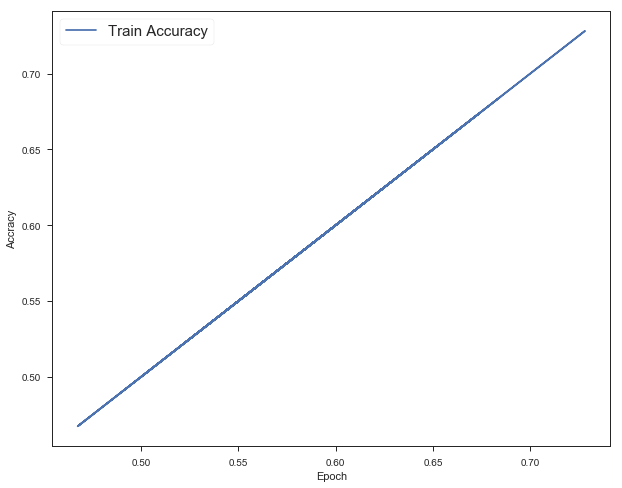

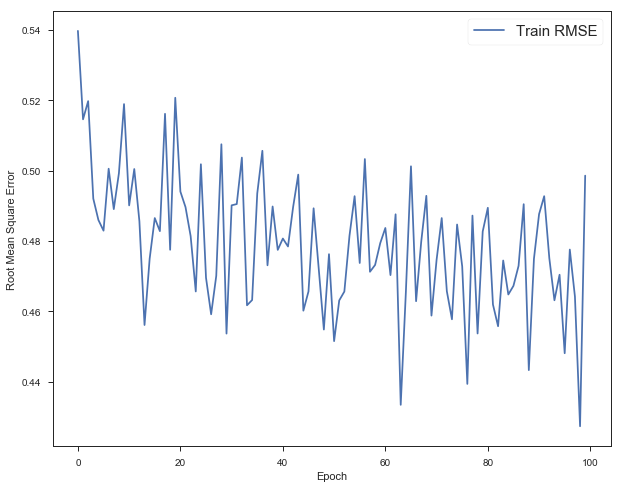

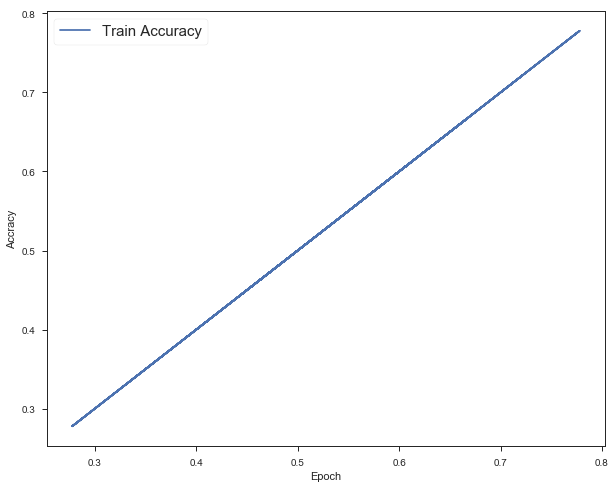

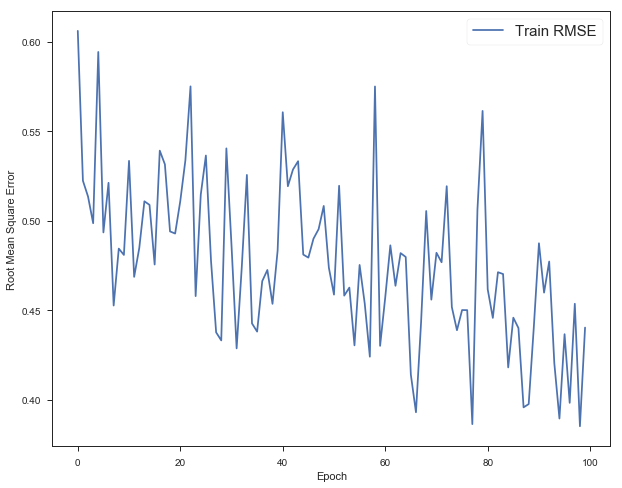

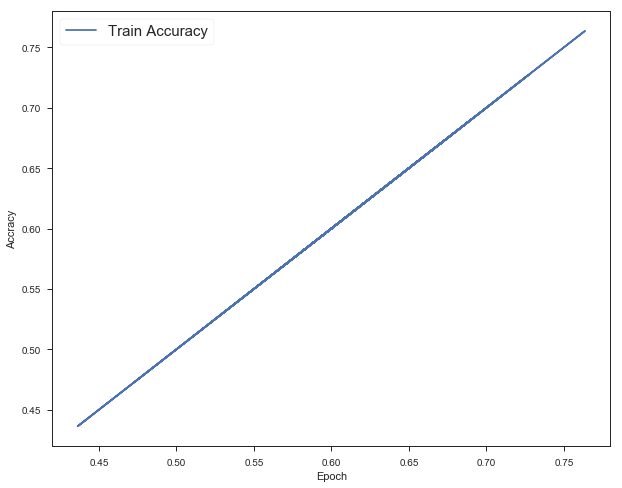

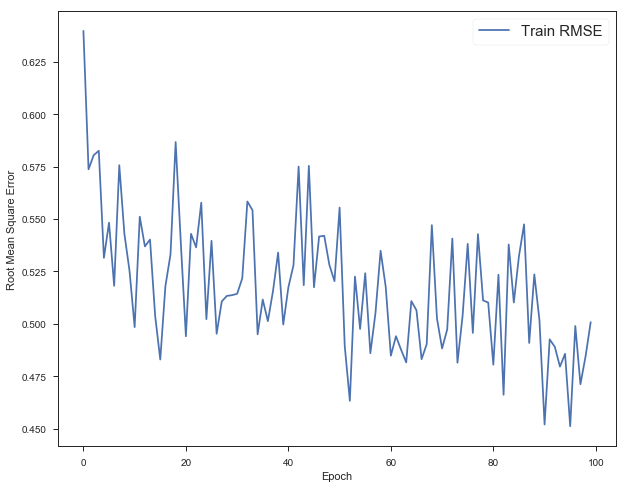

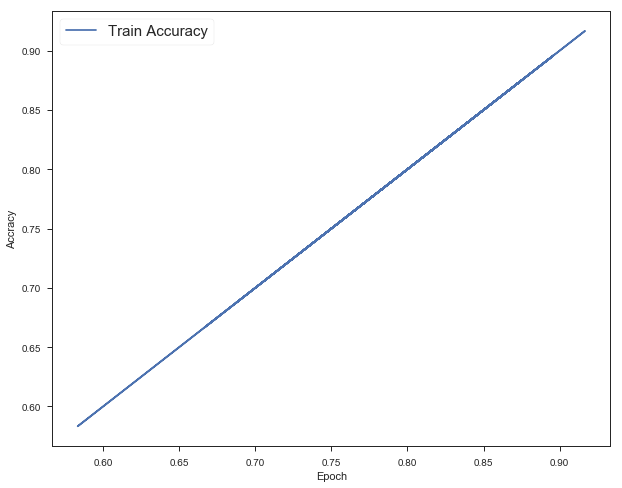

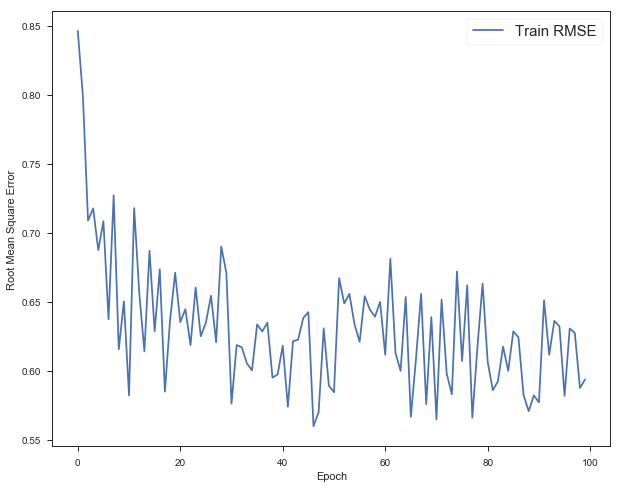

In [64]:
for region in regions:
    plot_history(performance_reg[region])

In [ ]:
summer_data.corr()['tn'].abs().sort_values(ascending=False)

### Make predictions

In [86]:
y_pred = model.predict(test_data_norm) 
y_pred = pd.DataFrame(y_pred, columns = ['tn', 'tp'])
y_pred.tail()

,tn,tp
306,0.182164,1.806039e-02
307,0.094643,5.025864e-04
308,0.100583,4.844606e-03
309,0.143965,7.281274e-03
310,0.017654,1.083083e-14


In [89]:
r2_score(test_labels_norm['tp'], y_pred['tp'])

0.07634647947525008

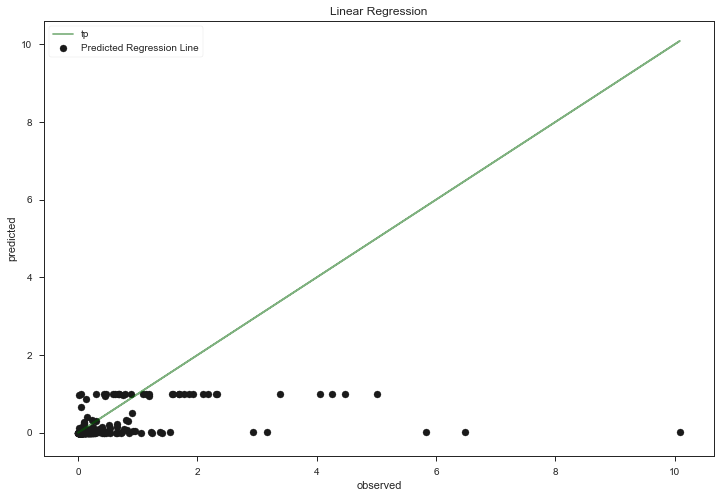

In [88]:
plt.figure(figsize=(12,8))
plt.plot(test_labels_norm['tp'], test_labels_norm['tp'], color='darkgreen', alpha = 0.5) 
plt.scatter(test_labels_norm['tp'], y_pred['tp'], color= "k", label = "Predicted Regression Line")

plt.title('Linear Regression')
plt.legend()
plt.xlabel('observed')
plt.ylabel('predicted')
plt.show()

In [1]:
# Evaluate model
# scores = model.evaluate(test_labels_norm['tn'], y_pred['tn'])
# print ("\n Training Accuracy - %s: %.2f%%" % (model.metrics_names[4], scores[4]*100))

In [ ]:
plt.figure(figsize=(12,8))
plt.plot(y_test['tn'], y_test['tn'], color='darkgreen', alpha = 0.5) 
plt.scatter(y_test['tn'], y_pred['tn'], color= "k", label = "Predicted Regression Line")

plt.title('Linear Regression')
plt.legend(loc = 2)
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.show()

In [ ]:
# Evaluate model
scores = model.evaluate(x_train, y_train['tn'])
print ("\n Training Accuracy - %s: %.2f%%" % (model.metrics_names[4], scores[4]*100))